In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from math import sqrt

/Users/shobians./Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:

csv_file = "merged_news_stock_data.csv"
df = pd.read_csv(csv_file, parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.dropna(subset=["Date"], inplace=True)
df.reset_index(drop=True, inplace=True)


In [4]:

def compute_rsi(series, period=14):
    delta = series.diff()
    gains = delta.where(delta > 0, 0.0)
    losses = -delta.where(delta < 0, 0.0)
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    return 100.0 - (100.0 / (1.0 + rs))

def compute_macd(series, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = series.ewm(span=fastperiod, adjust=False).mean()
    ema_slow = series.ewm(span=slowperiod, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signalperiod, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

def compute_ma(series, window=20):
    return series.rolling(window=window).mean()


In [5]:

df["RSI"] = compute_rsi(df["Close_Price"])
df["MACD_line"], df["MACD_signal"], df["MACD_hist"] = compute_macd(df["Close_Price"])
df["MA20"] = compute_ma(df["Close_Price"])
df.dropna(inplace=True)
df["Close_next"] = df["Close_Price"].shift(-1)
df.dropna(inplace=True)


In [6]:
#     Feature Selection & Target Variable
feature_cols = ["RSI", "MACD_line", "MACD_signal", "MACD_hist", "MA20", 
                "sentiment_polarity", "sentiment_neg", "sentiment_neu", "sentiment_pos"]
target = "Close_next"

X = df[feature_cols]
y = df[target]

In [7]:

#     Scaling Features & Target Variable
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

#     Splitting Data Into Train & Test Sets (Consistent for All Models)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)


In [8]:
#     Function to Train & Evaluate Models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Trains the model, makes predictions, and evaluates performance."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2, y_pred


In [9]:
#     LSTM Model
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(1, X_train.shape[1])),
    Dropout(0.4),
    LSTM(64, return_sequences=True),
    Dropout(0.4),
    LSTM(32, return_sequences=False),
    Dropout(0.4),
    Dense(16, activation="relu"),
    Dense(1)
])

lstm_model.compile(optimizer=AdamW(learning_rate=0.0005), loss="mse")
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])

y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
lstm_rmse, lstm_r2 = sqrt(mean_squared_error(y_test, y_pred_lstm)), r2_score(y_test, y_pred_lstm)


Epoch 1/100


/Users/shobians./Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.7117
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0787
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0465
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0455
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0318
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0330
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0314
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0282
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0265
Epoch 10/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0274
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0268
Epoch 12/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0261
Epoch 13/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0289
Epoch 14/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0251
Epoch 15/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

In [10]:
#     Machine Learning Models
models = {
    "Linear Regression": LinearRegression(),
    "Optimized Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=10, max_features='sqrt', random_state=42),
    "Optimized XGBoost": XGBRegressor(subsample=1.0, n_estimators=500, max_depth=3, learning_rate=0.1, random_state=42),
    "Optimized LightGBM": LGBMRegressor(num_leaves=20, n_estimators=700, max_depth=5, learning_rate=0.5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    "SVR": SVR(kernel='rbf')
}

model_results = {}
model_predictions = {}

for model_name, model in models.items():
    rmse, r2, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test)
    model_results[model_name] = (rmse, r2)
    model_predictions[model_name] = y_pred


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2231
[LightGBM] [Info] Number of data points in the train set: 12758, number of used features: 9
[LightGBM] [Info] Start training from score 0.027931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [11]:
#     Convert Predictions Back to Actual Prices
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_lstm_actual = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()

for model_name in model_predictions.keys():
    model_predictions[model_name] = scaler.inverse_transform(model_predictions[model_name].reshape(-1, 1)).flatten()


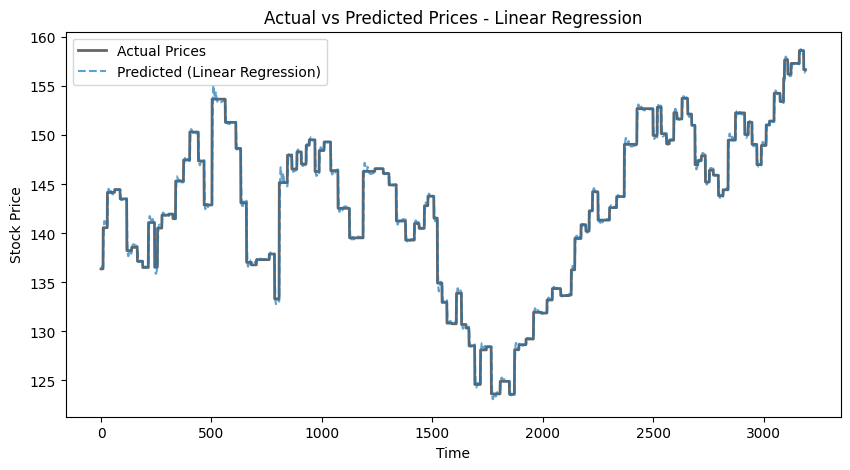

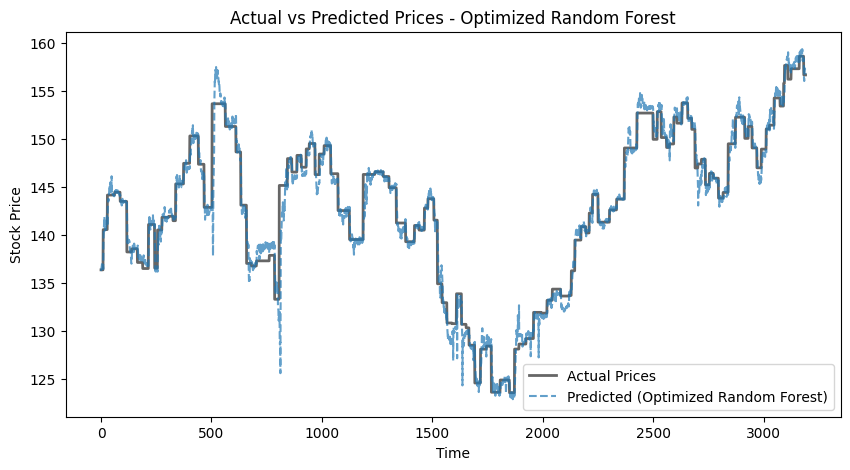

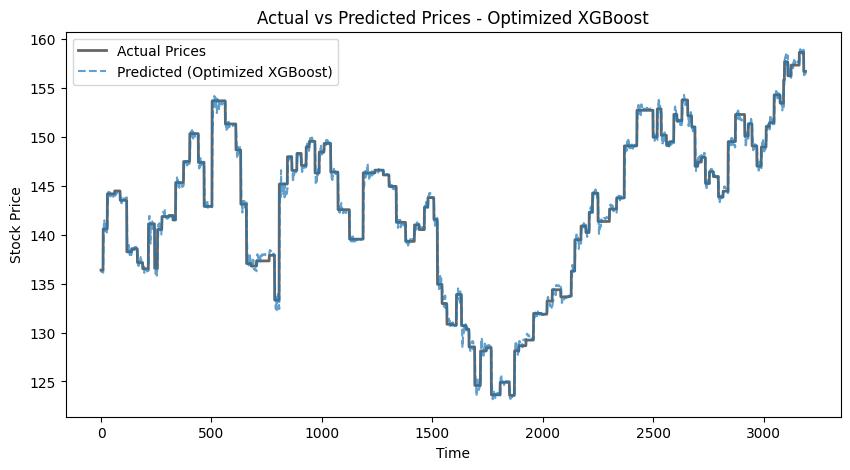

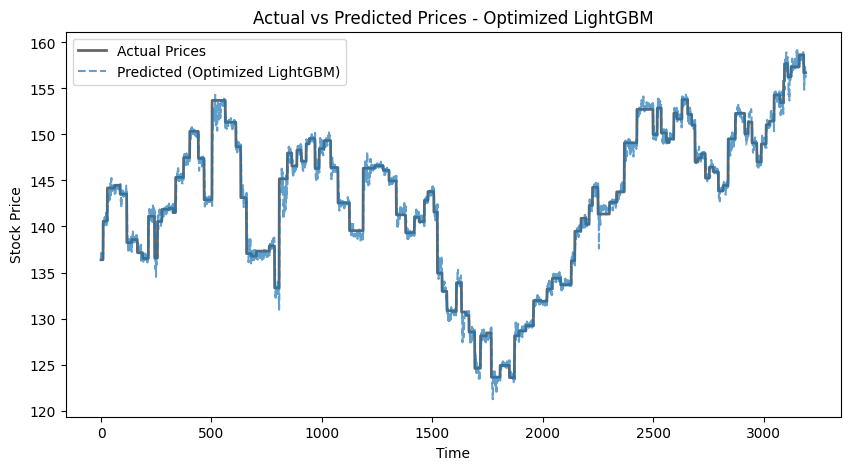

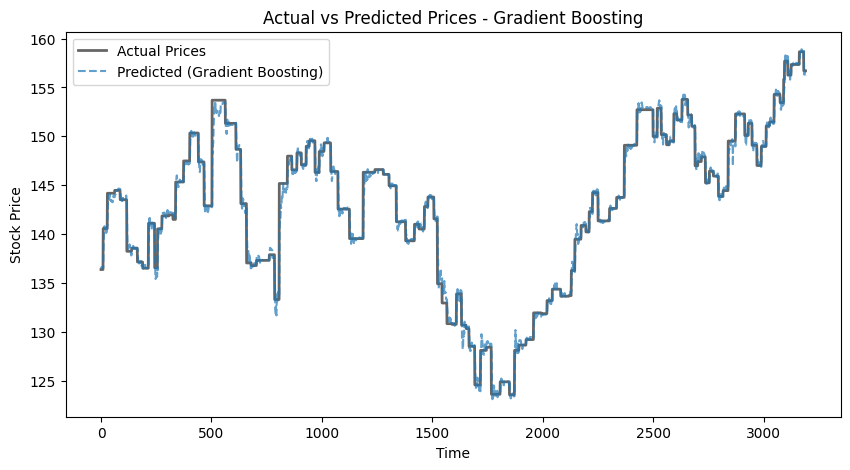

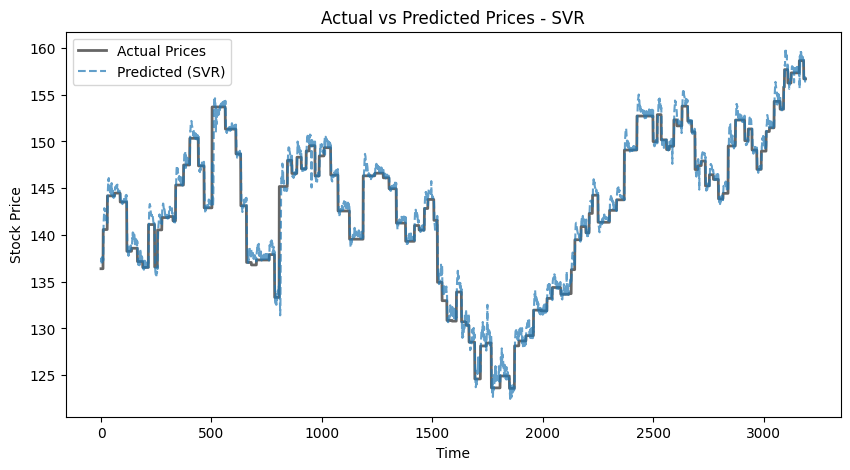

In [12]:
#     Plot Actual vs. Predicted Prices for Each Model
for model_name, predictions in model_predictions.items():
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, label="Actual Prices", color="black", linewidth=2, alpha=0.6)
    plt.plot(predictions, label=f"Predicted ({model_name})", linestyle="dashed", alpha=0.7)
    plt.title(f"Actual vs Predicted Prices - {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

In [13]:
#     Final Model Performance Comparison
results_df = pd.DataFrame(model_results, index=["RMSE", "R²"]).T
results_df.loc["Improved LSTM"] = [lstm_rmse, lstm_r2]


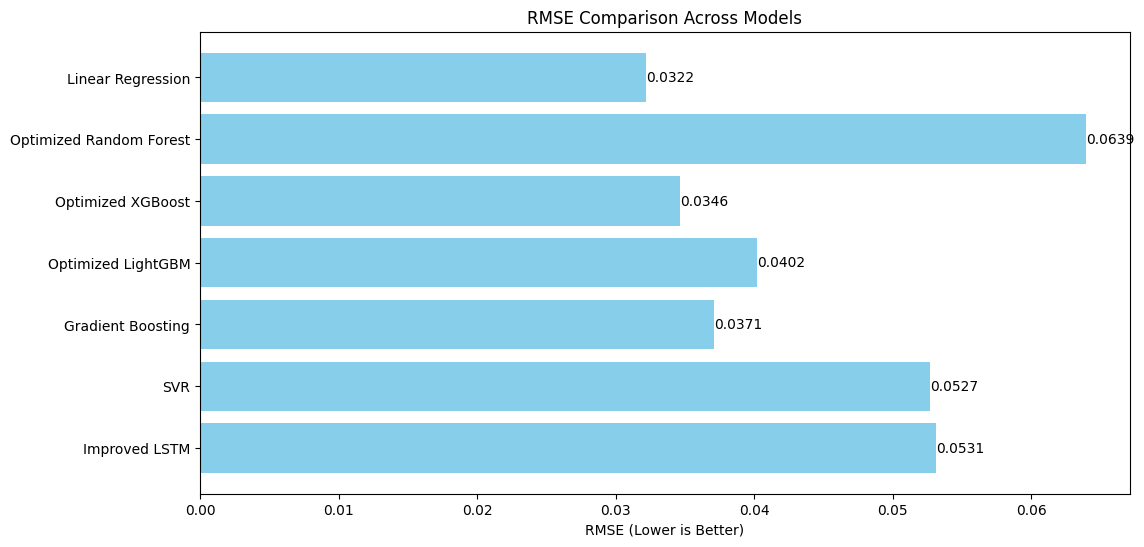

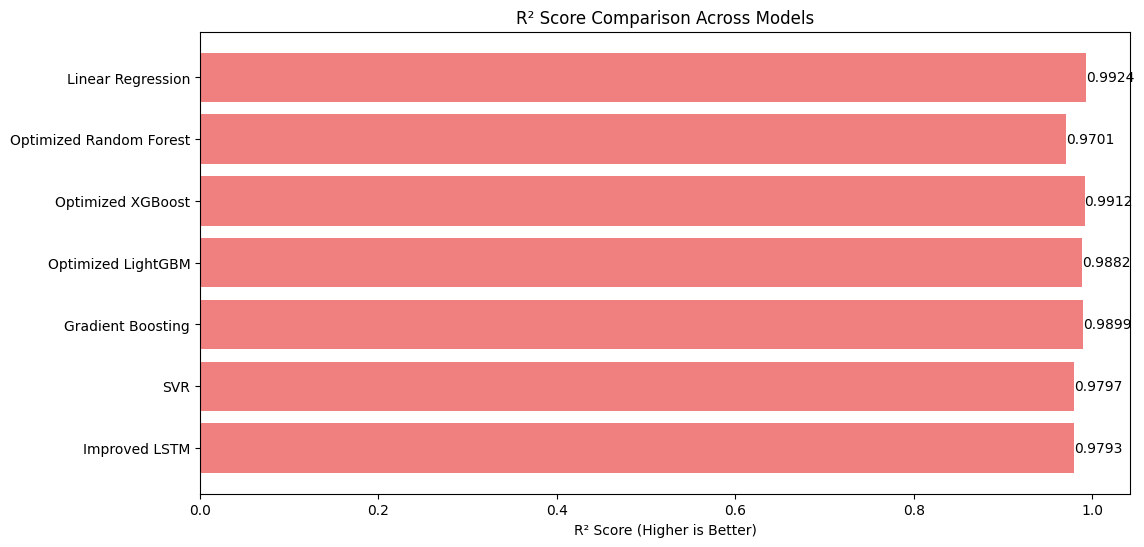

In [14]:
#     Plot RMSE & R² Score Comparison
plt.figure(figsize=(12, 6))
bars = plt.barh(results_df.index, results_df["RMSE"], color='skyblue')
plt.xlabel("RMSE (Lower is Better)")
plt.title("RMSE Comparison Across Models")

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', va='center')

plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 6))
bars = plt.barh(results_df.index, results_df["R²"], color='lightcoral')
plt.xlabel("R² Score (Higher is Better)")
plt.title("R² Score Comparison Across Models")

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', va='center')

plt.gca().invert_yaxis()
plt.show()